# Sample and Visualize from Dataset and DataLoader instances

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf VSD_foundation_model
!git clone --branch None_to_null https://github.com/ossnat/VSD_foundation_model.git
!ln -s '/content/drive/My Drive/VSD_FM/Data' '/content'

Cloning into 'VSD_foundation_model'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 542 (delta 126), reused 129 (delta 69), pack-reused 321 (from 1)
Receiving objects: 100% (542/542), 3.77 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (305/305), done.


In [4]:
import os
import sys
import yaml
import torch
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader, Subset

project_root = Path('VSD_foundation_model')
sys.path.insert(0, str(project_root))

from src.data import load_dataset, create_dataset, VsdVideoDataset
from src.models.backbone.mae_backbone_2d import MAEResNet18Backbone
from src.models.heads.mae_decoder_2d import MAEDecoder2D
from src.models.systems.mae_system import MAESystem
from src.training.trainer import Trainer

# Load config
config_path = "VSD_foundation_model/configs/default.yaml"
with open(config_path, 'r') as f:
  cfg = yaml.safe_load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cpu


## Visualize random sample from Dataset

In [5]:
# Initiate Dataset instacne
VSDdataset = VsdVideoDataset(cfg)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 3994 trials for split 'train'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.99

Visualizing random sample 47288 from dataset
Time taken to retrieve sample: 1.1142 seconds
Video tensor shape: torch.Size([1, 1, 100, 100])
Frame range: 128 to 128

📊 Plotting frames sequence...


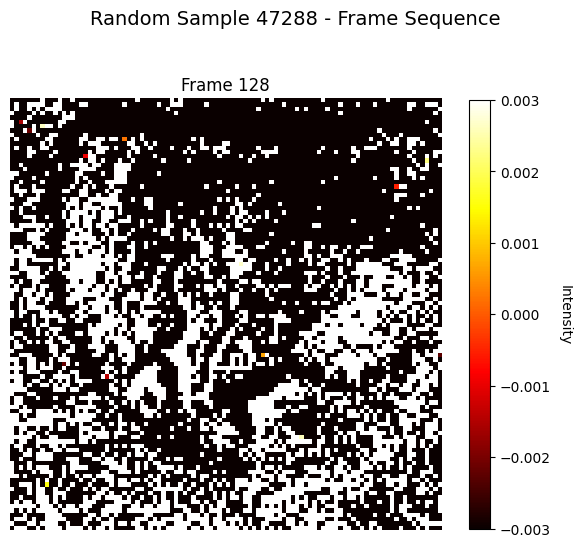


✅ Visualization complete!


In [7]:
# Visualize a random sample before splitting
import random
import matplotlib.pyplot as plt
from src.utils.visualization import plot_frames_sequence, plot_spatial_dynamics
import time

# Get a random sample
random_idx = random.randint(0, len(VSDdataset) - 1)

start_time = time.time()
sample = VSDdataset[random_idx]
end_time = time.time()

retrieval_time = end_time - start_time

video_tensor = sample["video"]  # (C, T, H, W)
start_frame = sample.get("start_frame", 0)
end_frame = sample.get("end_frame", 0)

print(f"Visualizing random sample {random_idx} from dataset")
print(f"Time taken to retrieve sample: {retrieval_time:.4f} seconds")
print(f"Video tensor shape: {video_tensor.shape}")
print(f"Frame range: {start_frame} to {end_frame}")

# Prepare real frame range for visualization
real_frame_range = (int(start_frame), int(end_frame)) if start_frame is not None and end_frame is not None else None

# Plot frames sequence
print("\n📊 Plotting frames sequence...")
fig1 = plot_frames_sequence(
    video_tensor=video_tensor,
    start_frame=0,
    end_frame=None,  # Use all frames
    clipping=(-0.003, 0.003),
    cols=10,
    title=f"Random Sample {random_idx} - Frame Sequence",
    show_plot=True,
    real_frame_range=real_frame_range
)

print("\n✅ Visualization complete!")

## Visualize from DataLoader

# Initiate DataLoader


In [9]:
batch_size=32
VSDloader = load_dataset(cfg, split="train", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 3994 trials for split 'train'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.99

Time taken to load batch: 4.2655 seconds
Visualizing random sample 5 from batch
Video tensor shape: torch.Size([1, 1, 100, 100])
Frame range: 35 to 35

📊 Plotting frames sequence...


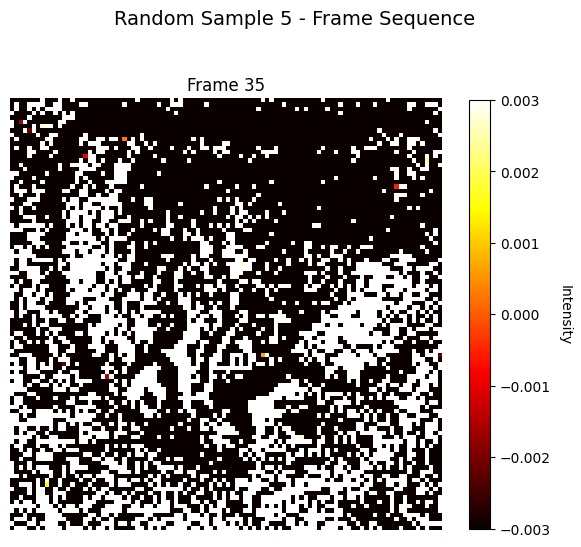


✅ Visualization complete!


In [13]:
# Get a batch
start_time_batch_load = time.time()
batch = next(iter(VSDloader))
end_time_batch_load = time.time()
batch_load_time = end_time_batch_load - start_time_batch_load

random_idx = random.randint(0, batch_size - 1)

sample = batch["video"][random_idx,:,:,:,:].squeeze(0)  # Remove batch dimension to make it (C, T, H, W)
start_frame = batch.get("start_frame", 0)[random_idx]
end_frame = batch.get("end_frame", 0)[random_idx]

print(f"Time taken to load batch: {batch_load_time:.4f} seconds")
print(f"Visualizing random sample {random_idx} from batch")
print(f"Video tensor shape: {video_tensor.shape}")
print(f"Frame range: {start_frame} to {end_frame}")

# Prepare real frame range for visualization
real_frame_range = (int(start_frame), int(end_frame)) if start_frame is not None and end_frame is not None else None

# Plot frames sequence
print("\n📊 Plotting frames sequence...")
fig1 = plot_frames_sequence(
    video_tensor=video_tensor,
    start_frame=0,
    end_frame=None,  # Use all frames
    clipping=(-0.003, 0.003),
    cols=10,
    title=f"Random Sample {random_idx} - Frame Sequence",
    show_plot=True,
    real_frame_range=real_frame_range
)

print("\n✅ Visualization complete!")